# Image Manipulation Detection-Object Eraser in Samsung Gallery
- Team: 32
- Member: 0816086 黃立鈞

In [645]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tool_box

## 1. Load Image
- real image
- forgery image
- ground truth mask

In [646]:
name = '1'
block_size = 10
forgery_img = cv2.imread(r'data\forgery/'+name+'.jpg')
real_img = cv2.imread(r'data\real/'+name+'.jpg')
mask = cv2.imread(r'data\mask/'+name+'.jpg')
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

## 2. Preprocess Image
1. Resize three images into 660*660 pixel.
2. Binarization the mask.

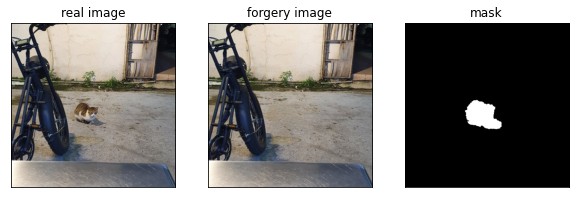

In [647]:
forgery_img = cv2.resize(forgery_img, (660,660),  interpolation=cv2.INTER_AREA)
mask = cv2.resize(mask, (660,660), interpolation=cv2.INTER_AREA)
real_img = cv2.resize(real_img, (660,660), interpolation=cv2.INTER_AREA)
_,mask = cv2.threshold(mask, 255/2, 255,cv2.THRESH_BINARY)

tool_box.show_image([
    cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB),
    cv2.cvtColor(forgery_img, cv2.COLOR_BGR2RGB),
    mask],
    ['real image','forgery image','mask'],
    [None, None, 'gray']
)



## 3. Noise Stream
### 3.1 Kernel Extraction
1. Use the kernel proposed in [this paper](https://arxiv.org/abs/1805.04953), which is sensitive to the manipulation region, to extract the image.

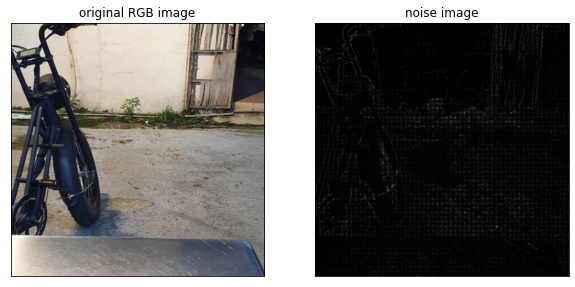

In [648]:
filtered1_forgery_img = tool_box.img_filter(forgery_img)
filtered1_forgery_img = cv2.normalize(filtered1_forgery_img, None, 0, 255, cv2.NORM_MINMAX)
filtered1_forgery_img = cv2.cvtColor(filtered1_forgery_img, cv2.COLOR_BGR2GRAY)
filtered1_forgery_img = cv2.normalize(filtered1_forgery_img,None,0, 255, cv2.NORM_MINMAX)

tool_box.show_image(
    [cv2.cvtColor(forgery_img, cv2.COLOR_BGR2RGB), filtered1_forgery_img],
    ['original RGB image','noise image'],
    [None, 'gray']
)


2. Use object enhanced kernel to reinforce the detected region.

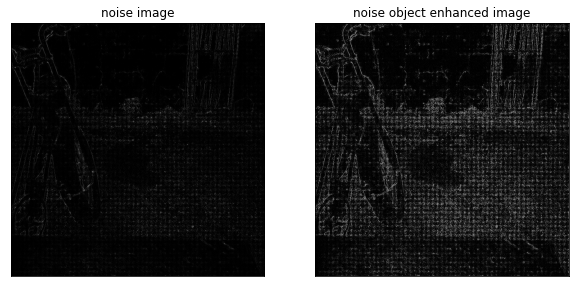

In [649]:
kernel = [
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]
kernel = np.asarray(kernel, dtype=float)
result_object = cv2.filter2D(filtered1_forgery_img, -1, kernel=kernel, anchor=(-1, -1), delta=0, borderType=cv2.BORDER_DEFAULT)
#img_object = cv2.filter2D(img, -1, kernel=kernel, anchor=(-1, -1), delta=0, borderType=cv2.BORDER_DEFAULT)

tool_box.show_image(
    [ filtered1_forgery_img, result_object],
    ['noise image', 'noise object enhanced image'],
    ['gray','gray']
)



### 3.2 Binarization
1. Simple invert binarization with threshold avg+std*2.

In [650]:
result_avg = np.average(result_object)
result_std = np.average(result_object)

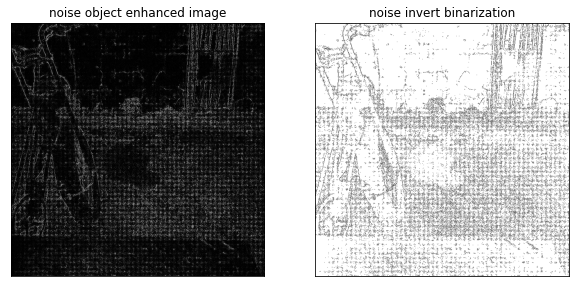

In [651]:
ret, bin = cv2.threshold(result_object, result_avg+result_std*2,255, cv2.THRESH_BINARY_INV)

tool_box.show_image(
    [  result_object, bin],
    [ 'noise object enhanced image', 'noise invert binarization'],
    ['gray','gray']
)

2. Block binarization with threshold avg.

In [652]:
print(np.average(bin))

227.1654269972452


In [653]:
print(np.std(bin))

79.51762484793413


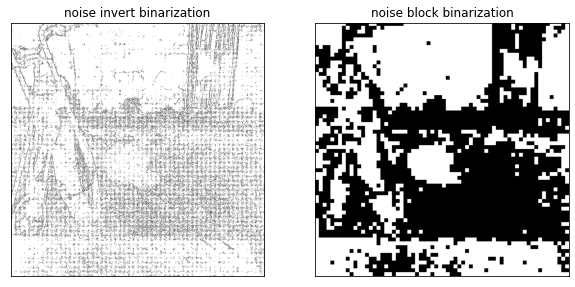

In [654]:
bin_block = tool_box.block_binary_filter(img=bin, block_size=block_size, thresh_hold=np.average(bin))
tool_box.show_image(
    [  bin, bin_block],
    [  'noise invert binarization','noise block binarization'],
    ['gray','gray']
)


## 4 Vector Stream
### 4.1 Gray scale

Text(0.5, 1.0, 'gray image')

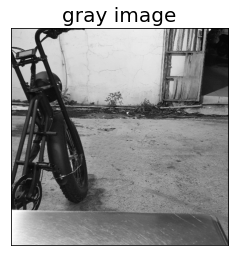

In [655]:
plt.imshow(cv2.cvtColor(forgery_img,cv2.COLOR_BGR2GRAY) ,'gray')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('gray image',fontsize=20)

### 4.2 Compute Gradient

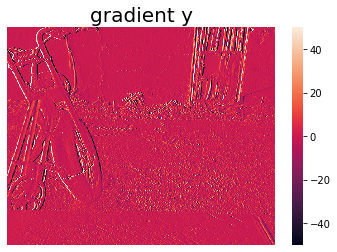

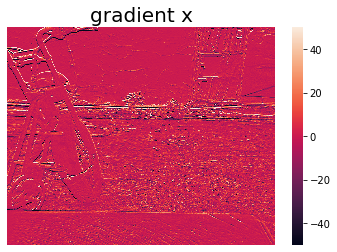

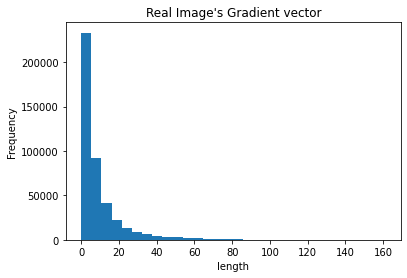

In [656]:
#org = cv2.imread('data/real/1.jpg')
#org_vector_length = generate_vector(cv2.cvtColor(org,cv2.COLOR_BGR2GRAY) )


vector_length = tool_box.generate_vector(cv2.cvtColor(forgery_img,cv2.COLOR_BGR2GRAY) )
#vector_length = np.sum(vector_length,axis=2) 
n, bins, patches=plt.hist(vector_length.flatten(),bins=30)
plt.xlabel("length")
plt.ylabel("Frequency")
plt.title("Real Image's Gradient vector")
plt.show()

Text(0.5, 1.0, 'vector length')

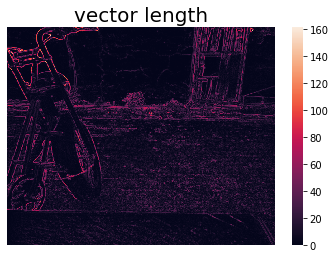

In [657]:
import seaborn as sns
sns.heatmap(vector_length)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('vector length',fontsize=20)
    

### 4.3 Vector Filtering

In [658]:
avg = np.average(vector_length)
std = np.std(np.array(vector_length,dtype=float))

In [659]:
_,inconststen = cv2.threshold(np.uint8(vector_length),5, 255, cv2.THRESH_BINARY)

Text(0.5, 1.0, 'vector filtering')

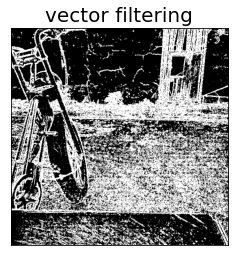

In [660]:
plt.imshow(inconststen ,'gray')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('vector filtering',fontsize=20)

### 4.4 Binarization

In [661]:
np.average(inconststen)

110.30330578512397

In [662]:
np.std(inconststen)

126.33496629231371

Text(0.5, 1.0, 'vector filtering with block binarization')

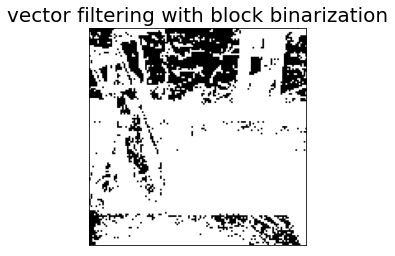

In [663]:
inconststen_bin = tool_box.block_binary_filter(inconststen,block_size=5, thresh_hold=1)
plt.imshow(inconststen_bin ,'gray')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('vector filtering with block binarization',fontsize=20)

## 5. Combination
Combine the result of noise stream and vector stream.

Text(0.5, 1.0, 'result')

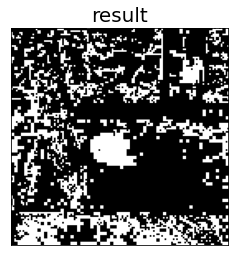

In [664]:
result = cv2.bitwise_and(bin_block,inconststen_bin)
plt.imshow(result ,'gray')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('result',fontsize=20)

### Prediction
Find the three largest connected components as the final prediction result.

In [665]:
import pandas as pd
ret, label= cv2.connectedComponents(result, connectivity=8)
uni = np.unique(label, return_counts=True)
uni = pd.Series(data=uni[1],index=uni[0])

In [666]:
uni = uni.sort_values(ascending=False)

In [667]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
def metrics(predict, mask):
    predict = predict.copy().flatten()
    mask = mask.copy().flatten()
    #print(np.unique(mask))
    #print(np.unique(predict))
    predict = np.uint8(predict)
    predict[predict==1] = 255
    
    #print(np.unique(predict))
    acc = accuracy_score(mask, predict)
    matrix = confusion_matrix(mask, predict)
    recall = recall_score(mask, predict, pos_label=255)
    f1 = f1_score(mask, predict, pos_label=255)
    #print('acc:',acc,'f1',f1,'coverage',recall,'\nmatrix',matrix)

    return {
        'f1':f1,
        'acc':acc,
        'coverage':recall,
        'matrix':matrix
    }

In [668]:
def save_prediction(predict):
    predict = np.uint8(predict)
    predict[predict==1] = 255
    cv2.imwrite('data\predict/'+name+'.jpg',predict)

In [669]:
result = pd.DataFrame(data=[],columns=['f1','acc','coverage','matrix'])
predictions = []
final_prediction = None

for i in range(3):
    predict = label==uni.index[i+1]
    eval = metrics(predict, mask)
    result.loc[i] = eval
    predictions.append(predict)
    if eval['f1'] >= 0.5:
        save_prediction(predict)
        final_prediction = predict


In [670]:
result

,f1,acc,coverage,matrix
0,0.000000,0.895760,0.000000,"[[390193, 34050], [11357, 0]]"
1,0.000000,0.932835,0.000000,"[[406343, 17900], [11357, 0]]"
2,0.893158,0.994522,0.878137,"[[423241, 1002], [1384, 9973]]"


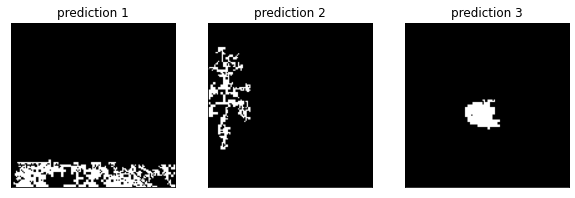

In [671]:
tool_box.show_image(
    predictions,
    ['prediction {}'.format(i+1) for i in range(3)],
    ['gray']*3
)

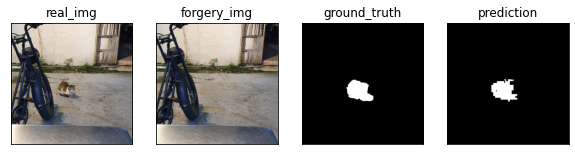

In [672]:
tool_box.show_image(
    [cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB),cv2.cvtColor(forgery_img, cv2.COLOR_BGR2RGB),mask,final_prediction],
    ['real_img','forgery_img','ground_truth','prediction'],
    [None,None,'gray','gray']
)